#LNDST


In [ ]:
!pip install -q ttach
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch

     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 163kB 10.5MB/s 


In [ ]:
# This is just the dataset with 8 pixels padding of images and their masks
!cp "/content/drive/My Drive/FNEWS/LDNST/data_lndst.zip" "."
!mkdir FinalData
!unzip -qq data_lndst -d FinalData/

In [ ]:
from fastai.vision import *
import os
import shutil
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
from torchvision import transforms
from glob import glob
import random

random.seed(42)

In [ ]:
size = 416
fold_id = 1

array([Image (3, 416, 416)], dtype=object)

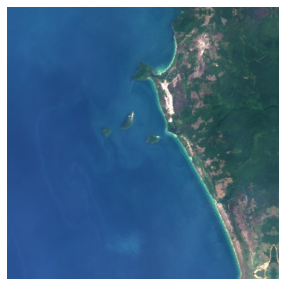

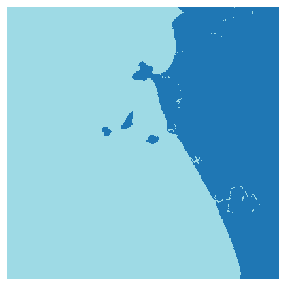

In [ ]:
path = Path('/content/FinalData/' + str(size))
path_lbl = path/'train_gt'
path_img = path/'train_images'

fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

# Mask Loader
def get_y_fn(x):
    dest = x.name.split('.')[0] + '.png'
    return path_lbl/dest

# open and show image
img_f = fnames[301]
img = open_image(img_f)
img.show(figsize=(5, 5))
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)
img_arr = open_image(str(get_y_fn(img_f)))
np.unique(img_arr)

# Split Data into train/val and create DataBunch Object


In [ ]:
splits = 5
n_samples = list(range(0, 1399))
random.Random(40).shuffle(n_samples)
kfold = [n_samples[i::splits] for i in range(splits)]

In [ ]:
fold = kfold[fold_id]
bs = 8
codes = ['background', 'water']

src = (SegmentationItemList.from_folder(path_img)
       # Load in x data from folder
      .split_by_idx(fold)
       # Split data into training and validation set 
       .label_from_func(get_y_fn, classes=codes)
       # Label data using the get_y_fn function
)

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

data = (src.transform(tfms, size=size, tfm_y=True)
        # Flip images horizontally 
        .databunch(bs=bs)
        # Create a databunch
        .normalize(imagenet_stats)
        # Normalize for resnet
)
data

ImageDataBunch;

Train: LabelList (1120 items)
x: SegmentationItemList
Image (3, 416, 416),Image (3, 416, 416),Image (3, 416, 416),Image (3, 416, 416),Image (3, 416, 416)
y: SegmentationLabelList
ImageSegment (1, 416, 416),ImageSegment (1, 416, 416),ImageSegment (1, 416, 416),ImageSegment (1, 416, 416),ImageSegment (1, 416, 416)
Path: /content/FinalData/416/train_images;

Valid: LabelList (279 items)
x: SegmentationItemList
Image (3, 416, 416),Image (3, 416, 416),Image (3, 416, 416),Image (3, 416, 416),Image (3, 416, 416)
y: SegmentationLabelList
ImageSegment (1, 416, 416),ImageSegment (1, 416, 416),ImageSegment (1, 416, 416),ImageSegment (1, 416, 416),ImageSegment (1, 416, 416)
Path: /content/FinalData/416/train_images;

Test: None

In [ ]:
def get_ex(): return open_image(fnames[200])

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

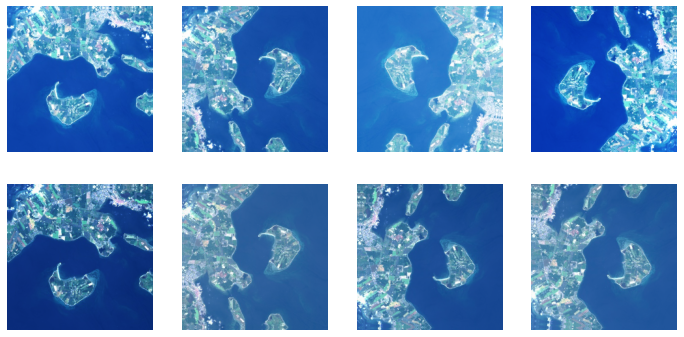

In [ ]:
plots_f(2, 4, 12, 6, size=224)

In [ ]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={'row_pct': 0.8601405968988218, 'col_pct': 0.7242167120755182, 'padding_mode': 'reflection'}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={'k': 4}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={'degrees': -4.860598308734754}, do_run=False, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.024092391493687, 'row_pct': 0.8064884937937665, 'col_pct': 0.746559350717045}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.45, 0.55)}, p=0.75, resolved={'change': 0.46151697074497594}, do_run=False, is_random=True, use_on_

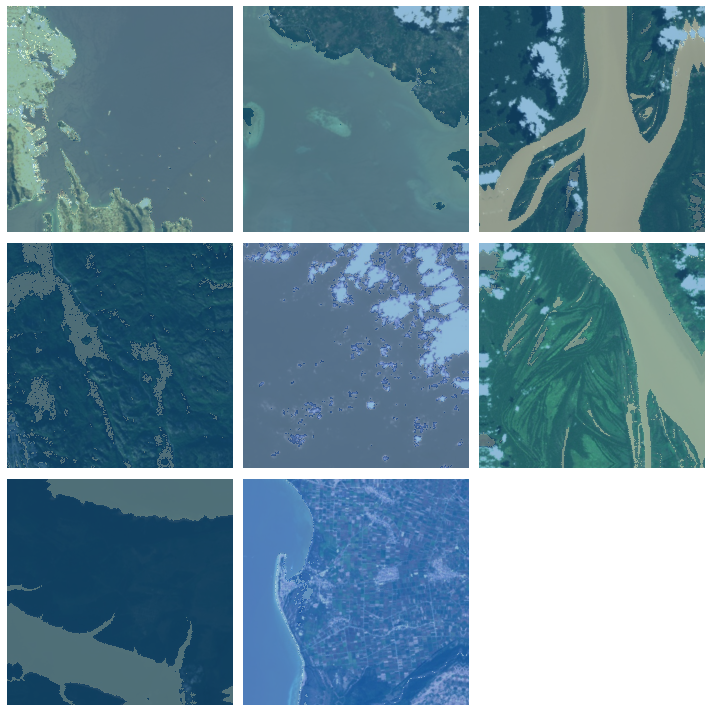

In [ ]:
data.show_batch(8, figsize=(10,10))

# Create Model

In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet('timm-efficientnet-b6', classes=2, encoder_weights='noisy-student', encoder_depth=5, decoder_channels=(512, 256, 128, 64, 32))
learn = Learner(data, model, metrics=[dice]).to_fp16()
learn.model_dir = './models'

In [ ]:
data.classes

['background', 'water']

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-03


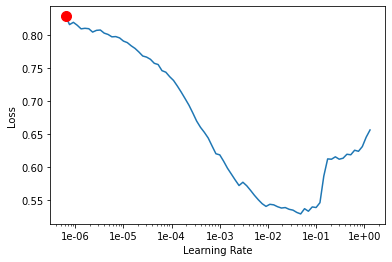

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
# stage 1
learn.fit_one_cycle(10, 1e-3)

In [ ]:
# stage 2
learn.fit_one_cycle(10, 1e-4)

In [ ]:
# stage 3
learn.fit_one_cycle(10, 1e-5, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='dice', name='best_unet_stage3')])

# Create Submission

In [ ]:
# FOR EFFNET ENSEMBLE TTA
from glob import glob
import cv2
from tqdm import tqdm
import segmentation_models_pytorch as smp
import ttach as tta

lst = sorted(glob('/content/FinalData/416/test_images/*') , key=lambda x: int(x.split('_')[-1].split('.')[0]))

PAD = 8

def return_learner(kfold):
  model = smp.Unet('timm-efficientnet-b6', classes=2, encoder_weights='noisy-student', encoder_depth=5, decoder_channels=(512, 256, 128, 64, 32))
  learn = Learner(data, model, metrics=[dice]).to_fp16()
  learn.model_dir = './models'
  learn.load(glob(f'/content/drive/My Drive/FNEWS/LDNST/*fold{kfold}*')[0].split('.')[0])
  learn.model = tta.SegmentationTTAWrapper(learn.model, tta.aliases.d4_transform(), merge_mode='mean')
  return learn

learn0 = return_learner(0)
learn1 = return_learner(1)
learn2 = return_learner(2)

main_array = []
for i in tqdm(lst):
  img = open_image(i)
  
  mask0 = learn0.predict(img)[2]
  mask1 = learn1.predict(img)[2]
  mask2 = learn2.predict(img)[2]

  mask = (mask0 + mask2 + mask1) / 3.
  mask = mask.argmax(dim=0)
  mask = mask.numpy().squeeze()

  mask = mask[PAD:-PAD, PAD:-PAD]
  mask = mask.flatten()
  main_array.append(mask)

main_array = np.asarray(main_array)
print(main_array.shape)
main_array_flat = np.reshape(main_array,(-1))
print(np.unique(main_array_flat))
print(main_array_flat.shape)
print(type(main_array_flat))
print(main_array_flat)
main_array_flat_uint = main_array_flat.astype(np.uint8)
with open('submission.npy', 'wb') as f:
    np.save(f,main_array_flat_uint)

100%|██████████| 467/467 [08:53<00:00,  1.14s/it]


(467, 160000)
[0 1]
(74720000,)
<class 'numpy.ndarray'>
[1 1 1 1 ... 0 0 0 0]
